In [1]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline


In [4]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [132]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

# Sepsis (Angus)

The query to get the Angus definition of sepsis is available in mimic_code. It collates information for each `hadm_id`, from `DIAGNOSES_ICD` for infection, organ dysfunction and explicit sespsis and `PROCEDURES_ICD` for mechanical ventilation. The Angus column is set to 1 if `explicit_sepsis` is 1, or if `infection` and `organ_dysfunction` are 1, or if `infection` and `mechanical ventilation` are 1. 

Note that both `DIAGNOSES_ICD` and `PROCEDURES_ICD` are only associated with `hadm_id` and not `icustay_id`. However, this should not be a problem if we filter the echos for single icu stays. 

In [136]:
query = \
"""
SELECT * FROM angus_sepsis;
"""
angus = pd.read_sql_query(query, con)
angus.head()

,subject_id,hadm_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus
0,22,165315,0,0,0,1,0
1,23,152223,0,0,0,0,0
2,23,124321,0,0,0,0,0
3,24,161859,0,0,0,0,0
4,25,129635,0,0,0,0,0


# Sepsis (proposed)

The proposed definition of sepsis from our last meeting was: 

+ On antibiotics
+ On pressors within 48 hours
+ Not in cardiogenic shock/pulmonary embolism/haem shock

Prescriptions are listed in the prescriptions table and have hadm_id, icustay_id, starttime and endtime. The drug is specified by name, as well as formulary_drug_cd, gsn and ndc. 

Is there a list of antibiotics/pressors to use? 

In [215]:
query = \
"""
SELECT * FROM PRESCRIPTIONS WHERE drug = 'Epinephrine';
"""
scrip = pd.read_sql_query(query, con)
scrip.head()

,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,drug_name_generic,formulary_drug_cd,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route
0,1380499,28,162569,225559.0,2177-09-01,2177-09-02,MAIN,Epinephrine,None,None,EPI1I,004931,00074724101,1 mg /1 mL,2,mg,2,AMP,IV DRIP
1,1384432,36,122659,211200.0,2131-05-19,2131-05-21,MAIN,Epinephrine,None,None,EPI1I,004931,00409724101,1mg /1mL,2,mg,2,AMP,IV DRIP
2,1680277,111,155897,249202.0,2144-07-01,2144-07-01,MAIN,Epinephrine,None,None,EPI1I,004937,42023012225,1mg /1mL Vial,2,mg,2,VIAL,IV DRIP
3,2317168,134,167887,NaN,2127-01-14,2127-01-15,MAIN,Epinephrine,None,None,EPI1I,004931,00074724101,1 mg /1 mL,2,mg,2,AMP,IV DRIP
4,1797661,137,151583,272335.0,2191-11-17,2191-11-17,MAIN,Epinephrine,None,None,EPI1I,004931,00409724101,1mg /1mL,2,mg,2,AMP,IV DRIP


Important ICD-9 codes:

+ Cardiogenic shock: 785.51
+ Pulmonary embolism: 415.1 (excludes chronic pulmonary embolism, persona history of pulmonary embolism, that complicating abortion, ectopic or molar pregnancy, pregnancy, childbirth or the peuperium)
+ Haem shock: ???

In [223]:
query = \
"""
SELECT * FROM DIAGNOSES_ICD
WHERE icd9_code = '78551' OR -- cardiogenic shock
      substring(icd9_code, 1, 4) = '4151' -- pulmonary embolism
"""
diag = pd.read_sql_query(query, con)
diag.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,75,17,161087,3,78551
1,113,21,109451,2,78551
2,265,36,122659,3,41511
3,276,36,165660,2,41511
4,2957,245,105501,5,78551


# ICU stays with associated echos

Extract information about icustays where the icustay_id/hadm_id is associated with an echo. Filter hadm_ids which have multiple icustay_ids. 

In [210]:
query = \
"""
SELECT * FROM echo_icustay;
"""
icu = pd.read_sql_query(query, con)
icu.head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,outtime,gender,subject_id,dod,admittime,dischtime,ethnicity,age,time_to_echo,max_icustay_seq,time_filter
0,76338,100003,2150-04-18 12:36:00,209281,2.0,1,Y,2150-04-19 14:12:52,M,54610,2150-12-28,2150-04-17 15:34:00,2150-04-21 17:30:00,WHITE,59.9110,0 days 21:02:00,1,True
1,68597,100006,2108-04-10 10:01:00,291788,5.0,1,Y,2108-04-11 15:18:03,F,9895,2109-10-24,2108-04-06 15:49:00,2108-04-18 17:18:00,BLACK/AFRICAN AMERICAN,48.9155,3 days 18:12:00,1,False
2,77734,100009,2162-05-17 14:55:00,253656,2.0,1,Y,2162-05-19 22:05:14,M,533,NaT,2162-05-16 15:56:00,2162-05-21 13:37:00,WHITE,60.7953,0 days 22:59:00,1,True
3,76984,100012,2177-03-14 12:46:00,239289,4.0,1,Y,2177-03-18 00:42:15,M,60039,NaT,2177-03-12 11:48:00,2177-03-22 14:30:00,WHITE,67.7113,2 days 00:58:00,1,False
4,76983,100012,2177-03-15 08:24:00,239289,4.0,1,Y,2177-03-18 00:42:15,M,60039,NaT,2177-03-12 11:48:00,2177-03-22 14:30:00,WHITE,67.7113,2 days 20:36:00,1,False


Comment out or edit `WHERE max_icustay_seq = 1` to be able to run the next two cells, which looks at the number of icustay_ids within a hadm_id, and an example where there are multiple icustay_ids within a hadm_id. 

In [68]:
icu.groupby('hadm_id')['icustay_id'].apply(lambda c: len(c.unique())).sort_values(ascending = False).value_counts()

1    21290
2     1861
3      257
4       47
5        7
6        3
7        2
Name: icustay_id, dtype: int64

In [69]:
icu.loc[icu['hadm_id'] == 186706].head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,gender,admittime,dischtime,ethnicity,admittime,max_icustay_seq
33799,72512,186706,2188-09-08 15:50:00,294576,8.0,1,Y,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33800,72879,186706,2188-09-19 16:32:00,294576,8.0,1,Y,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33801,72880,186706,2188-08-26 11:33:00,294576,8.0,1,Y,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33802,72879,186706,2188-09-19 16:32:00,240759,7.0,2,N,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33803,72512,186706,2188-09-08 15:50:00,240759,7.0,2,N,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7


There are 21290 such echos. 

## Distribution of number of echos by time w.r.t admittime

Count the number of echos between -8 to 48 hours

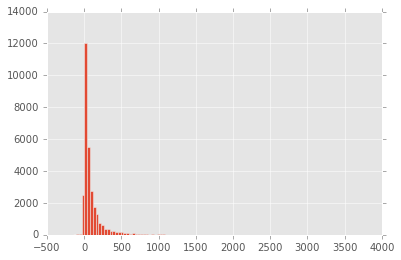

In [138]:
(icu['time_to_echo'] / np.timedelta64(1, 'h')).hist(bins = 100)

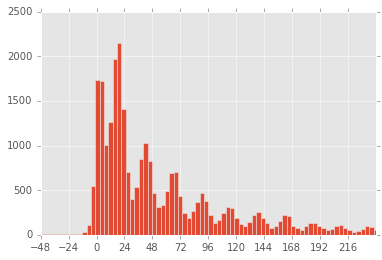

In [139]:
ax = (icu['time_to_echo'] / np.timedelta64(1, 'h')).hist(bins = 1000)
plt.xlim([-48, 240])
ticklabels = np.arange(-48, 240)[::24]
_ = plt.xticks(ticklabels)

In [141]:
((icu['time_to_echo'] > np.timedelta64(-8, 'h')) & 
 (icu['time_to_echo'] < np.timedelta64(48, 'h'))).value_counts()

True     16330
False    13385
Name: time_to_echo, dtype: int64

In [147]:
icu['time_filter'].value_counts()

True     16330
False    13385
Name: time_filter, dtype: int64

There are 16330 ICU echos that were taken between -8 to 48 h. The distributions on gender and age are computed on these: 

## Distribution on gender

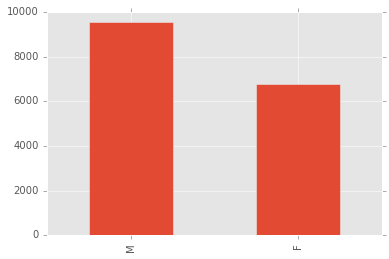

In [148]:
icu.loc[icu['time_filter'], 'gender'].value_counts().plot(kind = 'bar')

## Distribution on age

Computed as admittime - dob

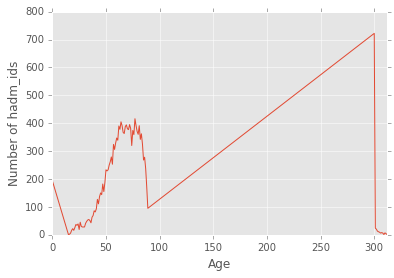

In [150]:
round(icu.loc[icu['time_filter'], 'age']).value_counts().sort_index().plot()
plt.xlabel('Age')
plt.ylabel('Number of hadm_ids')

## Number of echos associated with sepsis (Angus)

In [137]:
res = pd.merge(angus, icu, on = 'hadm_id', suffixes = ('_angus', '_icu'), how = 'right')
res.head()

,subject_id_angus,hadm_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus,row_id,charttime,icustay_id,...,first_icu_stay,gender,subject_id_icu,admittime,dischtime,ethnicity,age,time_to_echo,max_icustay_seq,time_filter
0,24,161859,0,0,0,0,0,78797,2139-06-08 10:31:00,262236,...,Y,M,24,2139-06-06 16:14:00,2139-06-09 12:48:00,WHITE,39.0152,1 days 18:17:00,1,True
1,25,129635,0,0,0,0,0,78499,2160-11-02 11:16:00,203487,...,Y,M,25,2160-11-02 02:06:00,2160-11-05 14:55:00,WHITE,58.9500,0 days 09:10:00,1,True
2,26,197661,0,0,0,0,0,65191,2126-05-10 11:47:00,244882,...,Y,M,26,2126-05-06 15:16:00,2126-05-13 15:00:00,UNKNOWN/NOT SPECIFIED,72.0043,3 days 20:31:00,1,False
3,30,104557,0,0,0,0,0,70141,2172-10-15 14:05:00,225176,...,Y,M,30,2172-10-14 14:17:00,2172-10-19 14:37:00,UNKNOWN/NOT SPECIFIED,300.0011,0 days 23:48:00,1,True
4,33,176176,1,0,0,0,0,61623,2116-12-24 09:22:00,296681,...,Y,M,33,2116-12-23 22:30:00,2116-12-27 12:05:00,UNKNOWN/NOT SPECIFIED,82.3919,0 days 10:52:00,1,True


In [138]:
res['explicit_sepsis'].value_counts()

0    26476
1     3239
Name: explicit_sepsis, dtype: int64

In [139]:
res['angus'].value_counts()

0    18555
1    11160
Name: angus, dtype: int64

## sofa scores associated with echos

In [140]:
query = \
"""
SELECT * FROM sofa;
"""
sofa = pd.read_sql_query(query, con)
sofa.head()

,subject_id,hadm_id,icustay_id,sofa,respiration,coagulation,liver,cardiovascular,cns,renal
0,55973,152234,200001,6,NaN,1.0,0.0,1.0,1.0,3.0
1,27513,163557,200003,6,2.0,1.0,2.0,1.0,0.0,0.0
2,10950,189514,200006,1,NaN,0.0,NaN,1.0,0.0,0.0
3,20707,129310,200007,1,NaN,0.0,NaN,1.0,0.0,0.0
4,29904,129607,200009,3,0.0,2.0,NaN,1.0,0.0,0.0


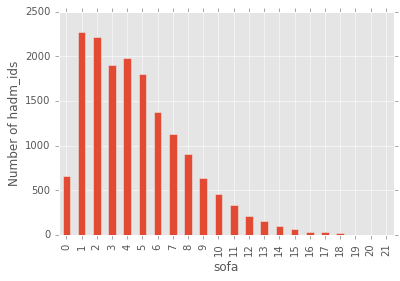

In [141]:
res = pd.merge(icu.loc[icu['time_filter']], sofa, on = 'hadm_id', suffixes = ('_icu', '_sofa'), how = 'left')

res['sofa'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('sofa')
plt.ylabel('Number of hadm_ids')

## qsofa scores associated with ICU echos

In [142]:
query = \
"""
SELECT * FROM qsofa;
"""
qsofa = pd.read_sql_query(query, con)
qsofa.head()

,subject_id,hadm_id,icustay_id,qsofa,sysbp_score,gcs_score,resprate_score
0,55973,152234,200001,2,1.0,0.0,1.0
1,27513,163557,200003,2,1.0,0.0,1.0
2,10950,189514,200006,2,1.0,0.0,1.0
3,20707,129310,200007,2,1.0,0.0,1.0
4,29904,129607,200009,2,1.0,0.0,1.0


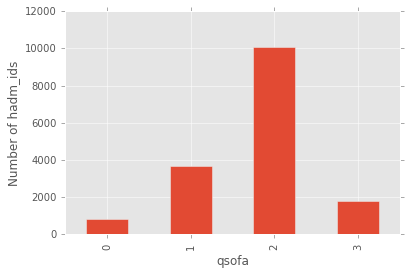

In [143]:
res = pd.merge(icu.loc[icu['time_filter']], qsofa, on = 'hadm_id', suffixes = ('_icu', '_qsofa'), how = 'left')

res['qsofa'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('qsofa')
plt.ylabel('Number of hadm_ids')

## Mortality in ICU

Compute number whose date of death <= icu outtime

In [213]:
res = icu.loc[icu['time_filter']]
(res['dod'] <= res['outtime']).value_counts()

False    14797
True      1533
dtype: int64

## Mortality in hospital

Compute number whose date of death <= hospital discharge time

In [214]:
res = icu.loc[icu['time_filter']]
(res['dod'] <= res['dischtime']).value_counts()

False    14547
True      1783
dtype: int64

## 30-day mortality

Compute number who died within 30 days of getting the echo

In [219]:
res = icu.loc[icu['time_filter']]
(res['charttime'] + pd.Timedelta(30, 'D') <= res['dod']).value_counts()

False    12077
True      4253
dtype: int64

# Outpatient echos

In [145]:
query = \
"""
SELECT * FROM echodata
WHERE status = 'Outpatient';
"""
echo_op = pd.read_sql_query(query, con)
echo_op.head()

,row_id,subject_id,hadm_id,chartdate,charttime,indication,height,weight,bsa,bp,bpsys,bpdias,hr,status,test,doppler,contrast,technicalquality
0,77922,7949,NaN,2124-08-31,2124-08-31 14:00:00,Preoperative assessment.,65.0,149.0,1.75,125/82,125.0,82.0,72.0,Outpatient,TTE (Complete),Full Doppler and color Doppler,None,Adequate
1,78193,25929,NaN,2201-06-04,2201-06-04 13:42:00,Aortic valve disease. Left ventricular function.,NaN,115.0,NaN,165/60,165.0,60.0,70.0,Outpatient,TTE (Complete),Full Doppler and color Doppler,None,Adequate
2,78194,25929,NaN,2200-05-14,2200-05-14 11:00:00,Follow up aortic regurgitation,NaN,NaN,NaN,142/78,142.0,78.0,NaN,Outpatient,TTE (Complete),Full doppler and color doppler,None,Adequate
3,78195,587,150352.0,2100-10-28,2100-10-28 13:45:00,Chemotherapy.,69.0,202.0,2.08,120/80,120.0,80.0,95.0,Outpatient,TTE (Complete),Full doppler and color doppler,None,Adequate
4,77945,11201,175064.0,2122-01-16,2122-01-16 11:45:00,Shortness of breath. Congestive heart failure...,67.0,185.0,1.96,120/68,120.0,68.0,88.0,Outpatient,TTE (Complete),Full doppler and color doppler,None,Suboptimal


For each ICU echo, calculate the chart time on the outpatient echo minus the chart time on the ICU echo: 

Number of ICU echos that have an outpatient echo before or after:

True     6854
False    5157
dtype: int64

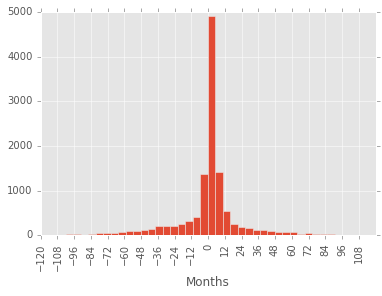

In [146]:
res = pd.merge(icu, echo_op, on = 'subject_id', suffixes = ('_icu', '_op'), how = 'inner')
((res['charttime_op'] - res['charttime_icu'])/ np.timedelta64(1, 'M')).hist(bins = 50)
plt.xlim([-12*10, 12*10])
ticklabels = np.arange(-120, 120)[::12]
_ = plt.xticks(ticklabels, rotation = 90)
plt.xlabel('Months')

(res['charttime_op'] > res['charttime_icu']).value_counts()

Looking at the pairs of echos where the outpatient echo occurred before the ICU echo, these are the indications for the outpatient echo. It doesn't look like they can be considered baseline echos? 

In [149]:
res.loc[res['charttime_icu'] > res['charttime_op']][[
        'charttime_op', 'charttime_icu', 'indication']].sample(n = 10)

,charttime_op,charttime_icu,indication
8686,2164-06-01 13:00:00,2165-02-22 10:06:00,Pericardial effusion. Interval change
6478,2165-09-25 09:00:00,2165-11-21 11:51:00,S/p repair of type A aortic dissection
10283,2136-08-22 09:00:00,2136-08-23 16:16:00,Evaluate for Coronary artery disease/Left vent...
999,2200-03-27 15:09:00,2200-04-28 15:48:00,Left ventricular function.
750,2170-08-03 09:00:00,2171-12-04 20:03:00,f/u cardiomyopathy
4642,2116-09-03 08:56:00,2116-11-09 09:20:00,Preoperative assessment.
8482,2142-07-20 08:15:00,2145-01-27 10:45:00,"chect pain, prior CAD"
168,2140-04-08 13:00:00,2144-09-21 11:48:00,Coronary artery disease. Left ventricular func...
354,2188-03-07 10:01:00,2188-03-17 13:08:00,Pericardial effusion. Left ventricular function.
1986,2192-08-23 15:00:00,2195-10-16 15:05:00,Coronary artery disease. Congestive heart fail...


# Dialysis

It is straightforward to ask which patients received dialysis during their stay. The rrt table determines if patients received any dialysis during their stay. 

In [94]:
query = \
"""
SELECT * FROM rrt;
"""
rrt = pd.read_sql_query(query, con)
rrt.head()

,subject_id,hadm_id,icustay_id,rrt
0,55973,152234,200001,1
1,27513,163557,200003,0
2,10950,189514,200006,0
3,20707,129310,200007,0
4,29904,129607,200009,0


In [113]:
rrt['icustay_id'].value_counts().value_counts() # check unique

1    61532
Name: icustay_id, dtype: int64

In [134]:
pd.merge(icu.loc[icu['time_filter']], rrt, on = 'icustay_id', how = 'left')['rrt'].value_counts()

0    15127
1     1203
Name: rrt, dtype: int64

As a side note, since dialysis counts as a procedure, the information could also show up in procedures_icd. Looking up the icd9 codes, 

In [122]:
query = \
"""
SELECT * FROM D_ICD_PROCEDURES 
WHERE long_title ~ '.+ialy.+';
"""
res = pd.read_sql_query(query, con)
res

,row_id,icd9_code,short_title,long_title
0,739,3927,Dialysis arteriovenostom,Arteriovenostomy for renal dialysis
1,746,3942,Revis ren dialysis shunt,Revision of arteriovenous shunt for renal dial...
2,747,3943,Remov ren dialysis shunt,Removal of arteriovenous shunt for renal dialysis
3,803,3895,Ven cath renal dialysis,Venous catheterization for renal dialysis
4,896,1255,Cyclodialysis,Cyclodialysis
5,1291,5498,Peritoneal dialysis,Peritoneal dialysis
6,1423,3995,Hemodialysis,Hemodialysis


In [124]:
query = \
"""
SELECT * FROM PROCEDURES_ICD pi 
INNER JOIN D_ICD_PROCEDURES dpi
    ON pi.icd9_code = dpi.icd9_code
WHERE dpi.long_title ~ '.+ialy.+';
"""
res = pd.read_sql_query(query, con)
res.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code,row_id,icd9_code,short_title,long_title
0,1015,10721,107493,2,3995,1423,3995,Hemodialysis,Hemodialysis
1,1019,25225,187093,1,3995,1423,3995,Hemodialysis,Hemodialysis
2,1036,3929,172648,2,3995,1423,3995,Hemodialysis,Hemodialysis
3,1037,3929,172648,3,3895,803,3895,Ven cath renal dialysis,Venous catheterization for renal dialysis
4,1100,7546,181171,1,3895,803,3895,Ven cath renal dialysis,Venous catheterization for renal dialysis


Now count the number of hadm_ids associated with dialysis-- this is a slightly smaller number than using the rrt table. 

In [129]:
len(set(res['hadm_id'].unique()) & set(icu.loc[icu['time_filter'], 'hadm_id']))

1048

One possibility is to collate EVERY indication of dialysis across all tables. Then, we can potentially start to ask questions about, for example, if a patient was on dialysis prior to the icustay, or how many patients are getting dialysis in the ICU. 

In [191]:
query = \
"""
SELECT * FROM dialysis;
"""
dialysis = pd.read_sql_query(query, con)
dialysis.head()

,subject_id,hadm_id,icustay_id,itemid,charttime,dbsource
0,8868,181556,286492.0,146,2133-10-31 08:00:00,carevue
1,8868,181556,286492.0,147,2133-10-31 08:00:00,carevue
2,8868,181556,286492.0,148,2133-10-31 08:00:00,carevue
3,8868,181556,286492.0,149,2133-10-31 08:00:00,carevue
4,8868,181556,286492.0,152,2133-10-31 08:00:00,carevue


We can ask, for example, for all patients with some kind of dialysis indicator and under carevue, how many have the code for INV Line?

In [199]:
res = dialysis.loc[dialysis['dbsource'] == 'carevue'].groupby('icustay_id')['itemid'].value_counts().unstack()
((~res[[229, 235, 241, 247, 253, 259, 265, 271]].isnull()).sum(axis = 1) > 0).value_counts()

True     1526
False     406
dtype: int64

We can also ask, again, for all patients with some kind of dialysis indicator and under carevue, how many have one of the dialysis-related procedures, 

In [200]:
res = dialysis.loc[dialysis['dbsource'] == 'carevue'].groupby('icustay_id')['itemid'].value_counts().unstack()
((~res[[582]].isnull()).sum(axis = 1) > 0).value_counts()

True     1446
False     486
dtype: int64

Similarly, for dialysis patients under metavision, how many had the code for dialysis catheter insertion date or dialysis cather placed in outside facility?

In [208]:
res = dialysis.loc[dialysis['dbsource'] == 'metavision'].groupby('icustay_id')['itemid'].value_counts().unstack()
((~res[[226118,225322]].isnull()).sum(axis = 1) > 0).value_counts()

True     1010
False     803
dtype: int64